Loaded 32071 simulations
Using sample 19857 → /mnt/data/darus/h5/19857.h5
Metadata: [1.000e+00 0.000e+00 0.000e+00 3.000e+01 1.025e+00 6.000e-02 9.700e-01
 4.000e+05]

--- Springback stats ---
Ground_Truth : mean=0.2586,  max=0.9525,  std=0.2042
Prediction   : mean=0.2597, max=1.0521, std=0.1902
Difference   : mean=0.0493,  max=0.1998,  std=0.0357

[LogNorm] vmin=0.00, vmax=0.30


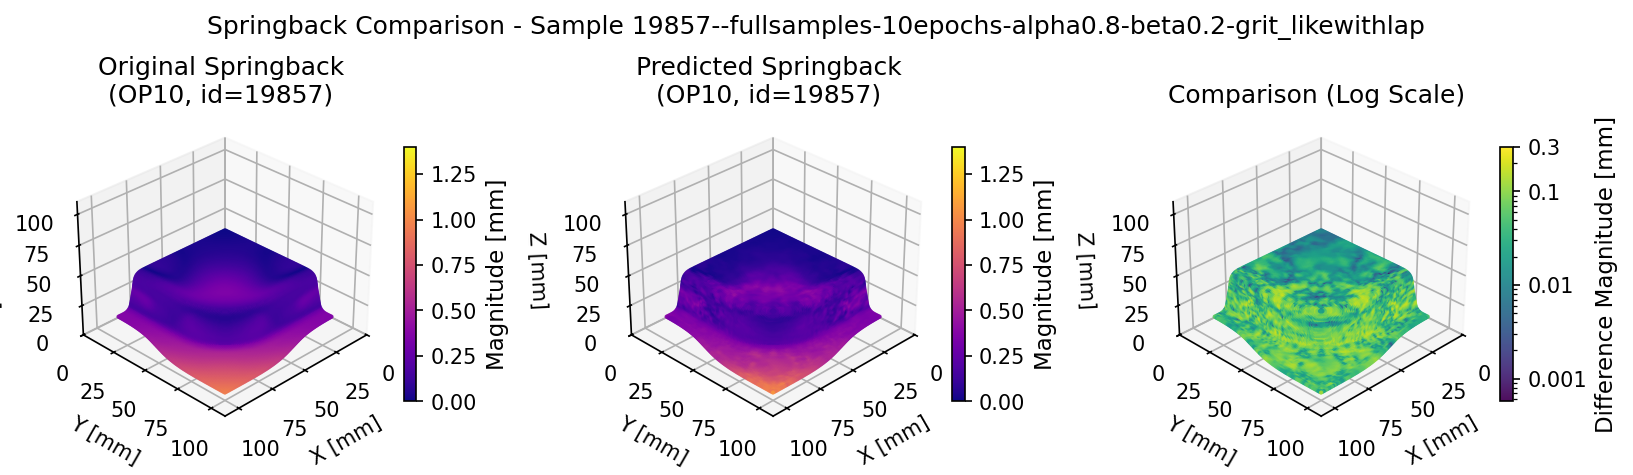

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm  # <-- added LogNorm
from matplotlib import ticker
from matplotlib.ticker import LogFormatter, LogLocator  # for log colorbar ticks
from pathlib import Path
from DDACSDataset import DDACSDataset
from utils_DDACS import extract_mesh, extract_point_springback

# Config
OPERATION   = 10
TIMESTEP    = 2
sample_id   = "16039"
pred_dir    = "/home/RUS_CIP/st186731/research_project/hybrid_approach/grit_like_and_graphormer_like/prediction/ddacs-node-regression/grit_like"
# pred_dir    = "/home/RUS_CIP/st186731/research_project/hybrid_approach/grit_like_and_graphormer_like/prediction/ddacs-node-regression/graphormer_like"
data_root   = "/mnt/data/jiang"
data_dir    = Path("/mnt/data/darus/")

FIGURE_SIZES = {
    "double_col": (7.0, 3.0),
}
FIGURE_SIZE = FIGURE_SIZES["double_col"]
FIGURE_DPI = 150
AXIS_LIMITS = [0, 110]
VIEW_ELEVATION = 30
VIEW_AZIMUTH = 45

def find_h5_by_id(dataset, sid):
    """Return (sim_id, metadata, h5_path) for the given string/int sample id."""
    sid = str(sid)
    for i in range(len(dataset)):
        sim_id, meta, h5_path = dataset[i]
        if str(sim_id) == sid:
            return sim_id, meta, h5_path
    raise FileNotFoundError(f"Sample id {sid} not found in dataset")

def add_colorbar(fig, ax, mappable, label):
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.8)
    # Auto formatting based on norm type
    if isinstance(mappable.norm, LogNorm):
        cbar.locator = LogLocator(base=10)
        cbar.formatter = LogFormatter(base=10, labelOnlyBase=False)
        cbar.update_ticks()
    else:
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    cbar.set_label(label, fontsize=11)

# Load dataset + files
dataset = DDACSDataset(data_dir, "h5")
print(f"Loaded {len(dataset)} simulations")

sim_id, metadata, h5_path = find_h5_by_id(dataset, sample_id)
print(f"Using sample {sim_id} → {h5_path}")
print(f"Metadata: {metadata}")

# Mesh
node_coords, triangles = extract_mesh(
    h5_path, operation=OPERATION, component='blank', timestep=TIMESTEP
)  # node_coords: (N,3)

# Original springback
final_coords_gt, disp_gt = extract_point_springback(h5_path, operation=OPERATION)

# Predicted springback
pred_path = os.path.join(pred_dir, f"{sample_id}_pred_node_displacement.npy")
disp_pred = np.load(pred_path)

# Compute magnitudes
mag_gt   = np.linalg.norm(disp_gt,   axis=1)  # [mm]
mag_pred = np.linalg.norm(disp_pred, axis=1)  # [mm]
difference_vector = disp_pred - disp_gt
difference_mag    = np.linalg.norm(difference_vector, axis=1)  # [mm] absolute L2 error per node

# Basic stats
print("\n--- Springback stats ---")
print(f"Ground_Truth : mean={mag_gt.mean():.4f},  max={mag_gt.max():.4f},  std={mag_gt.std():.4f}")
print(f"Prediction   : mean={mag_pred.mean():.4f}, max={mag_pred.max():.4f}, std={mag_pred.std():.4f}")
print(f"Difference   : mean={difference_mag.mean():.4f},  max={difference_mag.max():.4f},  std={difference_mag.std():.4f}")

# Coordinates to plot (use GT final pose for all panels for easy comparison)
coords_plot = node_coords + disp_gt

# Color normalization
global_springback_min = 0.0
global_springback_max = 1.4
norm_linear = Normalize(vmin=global_springback_min, vmax=global_springback_max)

# For the difference panel (log scale): vmin must be > 0
minimum_allowed_lower_bound = 1e-6
pos = difference_mag > 0
vmin_diff = max(minimum_allowed_lower_bound, difference_mag[pos].min())
global_springback_max_difference = 0.3
vmax_diff = global_springback_max_difference
norm_difference = LogNorm(vmin=vmin_diff, vmax=vmax_diff)

print(f"\n[LogNorm] vmin={vmin_diff:.2f}, vmax={global_springback_max_difference:.2f}")

# Figure
fig = plt.figure(figsize=(FIGURE_SIZE[0]*1.6, FIGURE_SIZE[1]), dpi=FIGURE_DPI)

# Precompute colors for the linear panels (GT & Pred)
col1 = plt.cm.plasma(norm_linear(mag_gt))
col2 = plt.cm.plasma(norm_linear(mag_pred))

diff_for_plot = np.clip(difference_mag, vmin_diff, None)

def add_colorbar(fig, ax, mappable, label):
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.8)
    if isinstance(mappable.norm, LogNorm):
        cbar.locator   = LogLocator(base=10, subs=(1.,))
        cbar.formatter = LogFormatter(base=10, labelOnlyBase=False)
        cbar.update_ticks()
    else:
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    cbar.set_label(label, fontsize=11)
    return cbar

# --- Panel 1: Original magnitude (linear) ---
ax1 = fig.add_subplot(131, projection="3d")
ax1.scatter(coords_plot[:,0], coords_plot[:,1], coords_plot[:,2], c=col1, s=1, alpha=0.9)
add_colorbar(fig, ax1, plt.cm.ScalarMappable(cmap="plasma", norm=norm_linear), "Magnitude [mm]")
ax1.set_title(f"Original Springback\n(OP{OPERATION}, id={sim_id})")
ax1.set_xlim(AXIS_LIMITS); ax1.set_ylim(AXIS_LIMITS); ax1.set_zlim(AXIS_LIMITS)
ax1.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)
ax1.set_xlabel("X [mm]"); ax1.set_ylabel("Y [mm]"); ax1.set_zlabel("Z [mm]")

# --- Panel 2: Predicted magnitude (linear) ---
ax2 = fig.add_subplot(132, projection="3d")
ax2.scatter(coords_plot[:,0], coords_plot[:,1], coords_plot[:,2], c=col2, s=1, alpha=0.9)
add_colorbar(fig, ax2, plt.cm.ScalarMappable(cmap="plasma", norm=norm_linear), "Magnitude [mm]")
ax2.set_title(f"Predicted Springback\n(OP{OPERATION}, id={sim_id})")
ax2.set_xlim(AXIS_LIMITS); ax2.set_ylim(AXIS_LIMITS); ax2.set_zlim(AXIS_LIMITS)
ax2.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)
ax2.set_xlabel("X [mm]"); ax2.set_ylabel("Y [mm]"); ax2.set_zlabel("Z [mm]")

# --- Panel 3: Difference ||pred - gt|| (LOG scale) ---
ax3 = fig.add_subplot(133, projection="3d")
sc3 = ax3.scatter(
    coords_plot[:, 0], coords_plot[:, 1], coords_plot[:, 2],
    c=diff_for_plot, cmap="viridis", norm=norm_difference,
    s=1, alpha=0.95
)

# Colorbar from the scatter mappable
cbar3 = fig.colorbar(sc3, ax=ax3, shrink=0.8)
#cbar3.ax.minorticks_off()                     # optional: hide minor ticks
cbar3.set_ticks([3e-1,1e-1, 1e-2, 1e-3,])                 # positions
cbar3.set_ticklabels(['0.3', '0.1','0.01', '0.001'])        # labels you want
cbar3.set_label("Difference Magnitude [mm]", fontsize=11)

ax3.set_title("Comparison (Log Scale)")
ax3.set_xlim(AXIS_LIMITS); ax3.set_ylim(AXIS_LIMITS); ax3.set_zlim(AXIS_LIMITS)
ax3.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)
ax3.set_xlabel("X [mm]"); ax3.set_ylabel("Y [mm]"); ax3.set_zlabel("Z [mm]")

# plt.suptitle(f"Springback Comparison - Sample {sim_id}-fullsamples-10epochs-alpha0.8-beta0.2-grit_likewithlap", y=0.98, fontsize=12)
plt.suptitle(f"Springback Comparison - Sample {sim_id}--fullsamples-10epochs-alpha0.8-beta0.2-grit_likewithlap", y=0.98, fontsize=12)
# plt.suptitle(f"Springback Comparison - Sample {sim_id}", y=0.98, fontsize=12)

save_dir = Path("/home/RUS_CIP/st186731/research_project/figures")
save_dir.mkdir(parents=True, exist_ok=True)

fig.tight_layout()  # arrange subplots nicely
if pred_dir == "/home/RUS_CIP/st186731/research_project/hybrid_approach/grit_like_and_graphormer_like/prediction/ddacs-node-regression/graphormer_like":
    fig.savefig(save_dir / f"springback_id{sample_id}_graphormer_like_with_lap_loss.png",
                dpi=150, bbox_inches="tight", pad_inches=0.1)
else:
    fig.savefig(save_dir / f"springback_id{sample_id}_grit_like_without_lap_loss_logscale-fullsamples-10epochs-alpha0.8-beta0.2-grit_likewithlap.png",
                dpi=150, bbox_inches="tight", pad_inches=0.1)

plt.show()


Loaded 32071 simulations
Using sample 16039 → /mnt/data/darus/h5/16039.h5
Metadata: [1.0e+00 0.0e+00 0.0e+00 3.0e+01 9.0e-01 5.0e-02 9.5e-01 1.0e+05]

--- Springback stats ---
Ground_Truth : mean=0.2124,  max=0.7167,  std=0.1983
Prediction   : mean=0.2300, max=0.9381, std=0.2136
Difference(L2 per-node) : mean=0.0526,  max=0.2957,  std=0.0362

--- Chamfer stats (L2) ---
Forward (GT→Pred): mean=0.052634, max=0.295744, std=0.036209
Backward(Pred→GT): mean=0.052634, max=0.295744, std=0.036209
Symmetric        : 0.105269

[LogNorm] vmin=1.21e-03, vmax=0.30


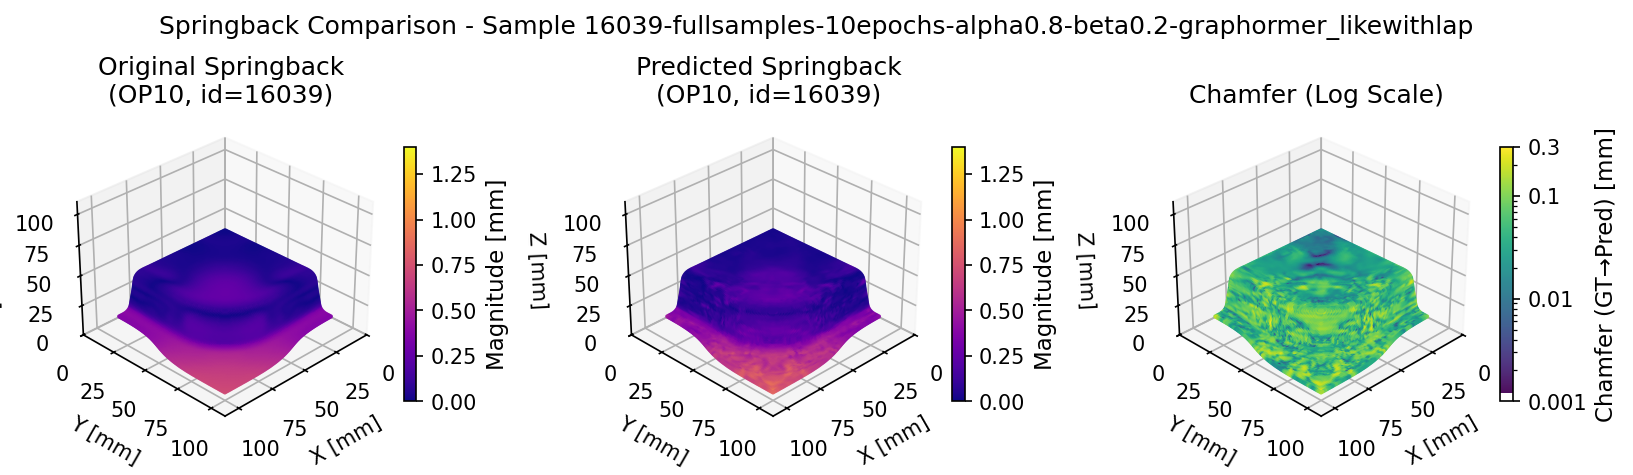

In [9]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm  
from matplotlib import ticker
from matplotlib.ticker import LogFormatter, LogLocator  # for log colorbar ticks
from pathlib import Path
from DDACSDataset import DDACSDataset
from utils_DDACS import extract_mesh, extract_point_springback
from scipy.spatial import cKDTree as KDTree

#  Config 
OPERATION   = 10
TIMESTEP    = 2
sample_id   = "16039"
# pred_dir    = "/home/RUS_CIP/st186731/research_project/hybrid_approach/grit_like_and_graphormer_like/prediction/ddacs-node-regression/grit_like-fullsamples-10epochs-alpha0.8-beta0.2-grit_likewithlap"
pred_dir  = "/home/RUS_CIP/st186731/research_project/hybrid_approach/grit_like_and_graphormer_like/prediction/ddacs-node-regression/graphormer_like"
data_root   = "/mnt/data/jiang"
data_dir    = Path("/mnt/data/darus/")

FIGURE_SIZES = {
    "double_col": (7.0, 3.0),
}
FIGURE_SIZE = FIGURE_SIZES["double_col"]
FIGURE_DPI = 150
AXIS_LIMITS = [0, 110]
VIEW_ELEVATION = 30
VIEW_AZIMUTH = 45

#  Utils 
def find_h5_by_id(dataset, sid):
    """Return (sim_id, metadata, h5_path) for the given string/int sample id."""
    sid = str(sid)
    for i in range(len(dataset)):
        sim_id, meta, h5_path = dataset[i]
        if str(sim_id) == sid:
            return sim_id, meta, h5_path
    raise FileNotFoundError(f"Sample id {sid} not found in dataset")

def add_colorbar(fig, ax, mappable, label):
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.8)
    # Auto formatting based on norm type
    if isinstance(mappable.norm, LogNorm):
        cbar.locator = LogLocator(base=10)
        cbar.formatter = LogFormatter(base=10, labelOnlyBase=False)
        cbar.update_ticks()
    else:
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    cbar.set_label(label, fontsize=11)

def nearest_neighbor_distances(query_points, reference_points):
    """
    Per-point NN distances from query_points to reference_points (L2).
    """
    
    tree = KDTree(reference_points)
        
    dists, _ = tree.query(query_points, k=1, workers=-1)

    return dists.astype(np.float64)
    

# -------------------- Load dataset + files --------------------
dataset = DDACSDataset(data_dir, "h5")
print(f"Loaded {len(dataset)} simulations")

sim_id, metadata, h5_path = find_h5_by_id(dataset, sample_id)
print(f"Using sample {sim_id} → {h5_path}")
print(f"Metadata: {metadata}")

# Mesh
node_coords, triangles = extract_mesh(
    h5_path, operation=OPERATION, component='blank', timestep=TIMESTEP
)  # node_coords: (N,3)

# Original springback
final_coords_gt, disp_gt = extract_point_springback(h5_path, operation=OPERATION)

# Predicted springback
pred_path = os.path.join(pred_dir, f"{sample_id}_pred_node_displacement.npy")
disp_pred = np.load(pred_path)

# Compute magnitudes
mag_gt   = np.linalg.norm(disp_gt,   axis=1)  # [mm]
mag_pred = np.linalg.norm(disp_pred, axis=1)  # [mm]
difference_vector = disp_pred - disp_gt
difference_mag    = np.linalg.norm(difference_vector, axis=1)  # [mm] absolute L2 error per node

# --------- Chamfer distances (GT↔Pred final positions) ---------
final_coords_pred = node_coords + disp_pred           # predicted final pose
# Forward (GT→Pred) and Backward (Pred→GT)
chamfer_forward  = nearest_neighbor_distances(final_coords_gt,  final_coords_pred)
chamfer_backward = nearest_neighbor_distances(final_coords_pred, final_coords_gt)
chamfer_symmetric = chamfer_forward.mean() + chamfer_backward.mean()

# Basic stats
print("\n--- Springback stats ---")
print(f"Ground_Truth : mean={mag_gt.mean():.4f},  max={mag_gt.max():.4f},  std={mag_gt.std():.4f}")
print(f"Prediction   : mean={mag_pred.mean():.4f}, max={mag_pred.max():.4f}, std={mag_pred.std():.4f}")
print(f"Difference(L2 per-node) : mean={difference_mag.mean():.4f},  max={difference_mag.max():.4f},  std={difference_mag.std():.4f}")

print("\n--- Chamfer stats (L2) ---")
print(f"Forward (GT→Pred): mean={chamfer_forward.mean():.6f}, max={chamfer_forward.max():.6f}, std={chamfer_forward.std():.6f}")
print(f"Backward(Pred→GT): mean={chamfer_backward.mean():.6f}, max={chamfer_backward.max():.6f}, std={chamfer_backward.std():.6f}")
print(f"Symmetric        : {chamfer_symmetric:.6f}")

# Coordinates to plot (use GT final pose for all panels for easy comparison)
coords_plot = node_coords + disp_gt

# Color normalization
global_springback_min = 0.0
global_springback_max = 1.4
norm_linear = Normalize(vmin=global_springback_min, vmax=global_springback_max)

# For the difference panel (log scale): use Chamfer forward (GT→Pred)
per_point_difference = chamfer_forward
minimum_allowed_lower_bound = 1e-6
pos_mask = per_point_difference > 0
vmin_diff = max(minimum_allowed_lower_bound, per_point_difference[pos_mask].min() if np.any(pos_mask) else minimum_allowed_lower_bound)
global_springback_max_difference = 0.3
vmax_diff = global_springback_max_difference
norm_difference = LogNorm(vmin=vmin_diff, vmax=vmax_diff)

print(f"\n[LogNorm] vmin={vmin_diff:.2e}, vmax={global_springback_max_difference:.2f}")

# Figure
fig = plt.figure(figsize=(FIGURE_SIZE[0]*1.6, FIGURE_SIZE[1]), dpi=FIGURE_DPI)

# Precompute colors for the linear panels (GT & Pred)
col1 = plt.cm.plasma(norm_linear(mag_gt))
col2 = plt.cm.plasma(norm_linear(mag_pred))

diff_for_plot = np.clip(per_point_difference, vmin_diff, None)

# (re)define add_colorbar with LogNorm subs for this figure
def add_colorbar(fig, ax, mappable, label):
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.8)
    if isinstance(mappable.norm, LogNorm):
        cbar.locator   = LogLocator(base=10, subs=(1.,))
        cbar.formatter = LogFormatter(base=10, labelOnlyBase=False)
        cbar.update_ticks()
    else:
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    cbar.set_label(label, fontsize=11)
    return cbar

# --- Panel 1: Original magnitude (linear) ---
ax1 = fig.add_subplot(131, projection="3d")
ax1.scatter(coords_plot[:,0], coords_plot[:,1], coords_plot[:,2], c=col1, s=1, alpha=0.9)
add_colorbar(fig, ax1, plt.cm.ScalarMappable(cmap="plasma", norm=norm_linear), "Magnitude [mm]")
ax1.set_title(f"Original Springback\n(OP{OPERATION}, id={sim_id})")
ax1.set_xlim(AXIS_LIMITS); ax1.set_ylim(AXIS_LIMITS); ax1.set_zlim(AXIS_LIMITS)
ax1.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)
ax1.set_xlabel("X [mm]"); ax1.set_ylabel("Y [mm]"); ax1.set_zlabel("Z [mm]")

# --- Panel 2: Predicted magnitude (linear) ---
ax2 = fig.add_subplot(132, projection="3d")
ax2.scatter(coords_plot[:,0], coords_plot[:,1], coords_plot[:,2], c=col2, s=1, alpha=0.9)
add_colorbar(fig, ax2, plt.cm.ScalarMappable(cmap="plasma", norm=norm_linear), "Magnitude [mm]")
ax2.set_title(f"Predicted Springback\n(OP{OPERATION}, id={sim_id})")
ax2.set_xlim(AXIS_LIMITS); ax2.set_ylim(AXIS_LIMITS); ax2.set_zlim(AXIS_LIMITS)
ax2.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)
ax2.set_xlabel("X [mm]"); ax2.set_ylabel("Y [mm]"); ax2.set_zlabel("Z [mm]")

# --- Panel 3: Chamfer ||GT→Pred|| (LOG scale) ---
ax3 = fig.add_subplot(133, projection="3d")
sc3 = ax3.scatter(
    coords_plot[:, 0], coords_plot[:, 1], coords_plot[:, 2],
    c=diff_for_plot, cmap="viridis", norm=norm_difference,
    s=1, alpha=0.95
)

# Colorbar from the scatter mappable
cbar3 = fig.colorbar(sc3, ax=ax3, shrink=0.8)
cbar3.set_ticks([3e-1, 1e-1, 1e-2, 1e-3])
cbar3.set_ticklabels(['0.3', '0.1', '0.01', '0.001'])
cbar3.set_label("Chamfer (GT→Pred) [mm]", fontsize=11)

ax3.set_title("Chamfer (Log Scale)")
ax3.set_xlim(AXIS_LIMITS); ax3.set_ylim(AXIS_LIMITS); ax3.set_zlim(AXIS_LIMITS)
ax3.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)
ax3.set_xlabel("X [mm]"); ax3.set_ylabel("Y [mm]"); ax3.set_zlabel("Z [mm]")

plt.suptitle(f"Springback Comparison - Sample {sim_id}-fullsamples-10epochs-alpha0.8-beta0.2-graphormer_likewithlap", y=0.98, fontsize=12)

save_dir = Path("/home/RUS_CIP/st186731/research_project/figures")
save_dir.mkdir(parents=True, exist_ok=True)

fig.tight_layout()  # arrange subplots nicely
if pred_dir == "/home/RUS_CIP/st186731/research_project/hybrid_approach/grit_like_and_graphormer_like/prediction/ddacs-node-regression/graphormer_like":
    fig.savefig(save_dir / f"springback_id{sample_id}_graphormer_like-fullsamples-10epochs-alpha0.8-beta0.2-graphormer_likewithlap.png",
                dpi=150, bbox_inches="tight", pad_inches=0.1)
else:
    fig.savefig(save_dir / f"springback_id{sample_id}_grit_like_chamfer-fullsamples-10epochs-alpha0.8-beta0.2-grit_likewithlap.png",
                dpi=150, bbox_inches="tight", pad_inches=0.1)

plt.show()


In [ ]:
import numpy as np
import h5py
from pathlib import Path
import os, sys
from DDACSDataset import DDACSDataset
from utils_DDACS import extract_mesh, extract_element_thickness, extract_point_springback, extract_point_cloud
import time

# ----------------- your existing helpers (unchanged) -----------------
def load_element_features(h5_path, component="blank", timestep=-1, op_form=20):
    with h5py.File(h5_path, "r") as f:
        comp = f[f"OP{op_form}"][component]
        stress_t = comp["element_shell_stress"][timestep]
        strain_t = comp["element_shell_strain"][timestep]
        thickness_t = comp["element_shell_thickness"][timestep]
    return np.concatenate(
        [
            stress_t.reshape(stress_t.shape[0], -1).astype(np.float32),  # 18
            strain_t.reshape(strain_t.shape[0], -1).astype(np.float32),  # 12
            thickness_t.reshape(thickness_t.shape[0], -1).astype(np.float32),  # 1
        ],
        axis=1,
    )  # (m,31)

def load_quad_mesh(h5_path, component="blank", op_form=20, timestep=-1):
    node_coords, triangles = extract_mesh(h5_path, operation=op_form, component=component, timestep=timestep)
    return node_coords.astype(np.float32), triangles.astype(np.int64)

def element_to_node_features(num_nodes, triangles, elem_features):
    node_feature_sums = np.zeros((num_nodes, elem_features.shape[1]), dtype=np.float32)
    node_counts = np.zeros(num_nodes, dtype=np.int32)
    for tri_idx in range(len(triangles)):
        tri_feat = elem_features[tri_idx]
        i, j, k = triangles[tri_idx]
        for n in (i, j, k):
            node_feature_sums[n] += tri_feat
            node_counts[n] += 1
    return node_feature_sums / np.maximum(node_counts[:, None], 1)

def load_displacement_op10(h5_path, operation=20):
    _, displacement_vectors = extract_point_springback(h5_path, operation)
    return displacement_vectors.astype(np.float32)

def add_edge(edges_dict, node_u, node_v, tri_idx):
    a, b = (node_u, node_v) if node_u < node_v else (node_v, node_u)
    if (a, b) not in edges_dict:
        edges_dict[(a, b)] = []
    edges_dict[(a, b)].append(tri_idx)

def build_edges_from_triangles(triangles):
    edges_dict = {}
    for tri_idx, (i, j, k) in enumerate(triangles):
        add_edge(edges_dict, i, j, tri_idx)
        add_edge(edges_dict, j, k, tri_idx)
        add_edge(edges_dict, k, i, tri_idx)
    keys = list(edges_dict.keys())
    edge_list = np.array(keys, dtype=np.int64)
    edge2tris = [edges_dict[k] for k in keys]
    return edge_list, edge2tris

def compute_edge_features(edge_index, edge2tris, repeated_elem_feats):
    E = edge_index.shape[0]
    F = repeated_elem_feats.shape[1]
    edge_features = np.zeros((E, F), dtype=np.float32)
    for e in range(E):
        tri_ids = np.asarray(edge2tris[e], dtype=np.int64)
        edge_features[e] = repeated_elem_feats[tri_ids].mean(axis=0)
    return edge_features

def build_edge_edge_index(edge_index, num_nodes=None):
    edge_index = np.asarray(edge_index, dtype=np.int64)
    if edge_index.size == 0:
        return np.empty((0, 2), dtype=np.int64)
    if num_nodes is None:
        num_nodes = int(edge_index.max()) + 1
    incident = [[] for _ in range(num_nodes)]
    for e_id, (u, v) in enumerate(edge_index):
        incident[u].append(e_id)
        incident[v].append(e_id)
    src, dst = [], []
    for edges_at_node in incident:
        d = len(edges_at_node)
        if d < 2: 
            continue
        for i in range(d - 1):
            ei = edges_at_node[i]
            for j in range(i + 1, d):
                ej = edges_at_node[j]
                if ei != ej:
                    src.append(ei); dst.append(ej)
                    src.append(ej); dst.append(ei)
    if not src:
        return np.empty((0, 2), dtype=np.int64)
    e2e = np.column_stack([np.asarray(src, dtype=np.int64), np.asarray(dst, dtype=np.int64)])
    return np.unique(e2e, axis=0)

def prepare_sample(h5_path, component="blank", op_form=20, timestep=1):
    concatenated_features = load_element_features(h5_path, component, timestep, op_form)  # (m,31)
    repeated_elem_feats = np.repeat(concatenated_features, 2, axis=0)                     # (2m,31)
    node_coords, triangles = load_quad_mesh(h5_path, component, op_form, timestep)        # (N,3), (2m,3)
    raw_displacement = load_displacement_op10(h5_path)                                     # (N,3)
    num_nodes = raw_displacement.shape[0]
    node_index = np.arange(num_nodes, dtype=np.int64)
    avg_node_feats = element_to_node_features(num_nodes, triangles, repeated_elem_feats)   # (N,31)
    new_concatenated_features = np.concatenate([node_coords, avg_node_feats], axis=1)      # (N,34)
    edge_index, edge2tris = build_edges_from_triangles(triangles)                          # (E,2)
    edge_features = compute_edge_features(edge_index, edge2tris, repeated_elem_feats)      # (E,31)
    edge_index_2 = np.arange(edge_index.shape[0], dtype=np.int64)                          # (E,)
    edge_edge_index = build_edge_edge_index(edge_index)                                     # (M,2)
    return (
        new_concatenated_features.astype(np.float32),
        raw_displacement.astype(np.float32),
        edge_index.astype(np.int64),
        edge_features.astype(np.float32),
        node_coords.astype(np.float32),
        node_index,
        edge_index_2,
        edge_edge_index.astype(np.int64),
    )
# ---------------------------------------------------------------------

def npz_path(out_dir: Path, sample_id: str | int) -> Path:
    return out_dir / f"{sample_id}.npz"

def _get_sample_by_id(ddacs, target_id: str | int):
    target_id = str(target_id)
    for i in range(len(ddacs)):
        sid, _, h5_path = ddacs[i]
        if str(sid) == target_id:
            return i, sid, h5_path
    raise ValueError(f"Sample id {target_id} not found in dataset.")

def save_one_sample(ddacs, out_dir: Path, *, sample_id: str | int = None, idx: int = None):
    """
    Save exactly one NPZ bundle.
    Provide either sample_id (preferred) or idx (0-based dataset index).
    """
    out_dir.mkdir(parents=True, exist_ok=True)

    if idx is not None and sample_id is not None:
        raise ValueError("Provide either sample_id or idx, not both.")
    if idx is None and sample_id is None:
        raise ValueError("You must provide sample_id or idx.")

    if idx is not None:
        sid, _, h5_path = ddacs[idx]
    else:
        _, sid, h5_path = _get_sample_by_id(ddacs, sample_id)

    t0 = time.perf_counter()
    X, Y, EI, EF, POS, NODE_IDX, EI_2, EEI = prepare_sample(h5_path)
    np.savez(
        npz_path(out_dir, sid),
        new_concatenated_features=X,
        node_displacement=Y,
        edge_index=EI,
        edge_features=EF,
        node_coords=POS,
        node_index=NODE_IDX,
        edge_index_2=EI_2,
        edge_edge_index=EEI,
    )
    dt = time.perf_counter() - t0
    print(f"Saved sample {sid} → {npz_path(out_dir, sid)} in {dt:.2f}s")
    print(f"X:{X.shape}  Y:{Y.shape}  EI:{EI.shape}  EF:{EF.shape}  POS:{POS.shape}  EEI:{EEI.shape}")

def check_one_sample(out_dir: Path, *, sample_id: str | int):
    fp = npz_path(out_dir, sample_id)
    if not fp.exists():
        raise FileNotFoundError(f"{fp} not found. Save it first.")
    with np.load(fp) as z:
        X  = z["new_concatenated_features"]
        Y  = z["node_displacement"]
        EI = z["edge_index"]
        EF = z["edge_features"]
        POS = z["node_coords"]
        NODE_IDX = z["node_index"]
        EI_2 = z["edge_index_2"]
        EEI = z["edge_edge_index"]
        print("-----------------------------------")
        print(f"For sample {sample_id} (NPZ bundle):")
        print("-----------------------------------")
        print(f"new_concatenated_features: {X.shape}")
        print(f"node_displacement:        {Y.shape}")
        print(f"edge_index:               {EI.shape}")
        print(f"edge_features:            {EF.shape}")
        print(f"node_coords:              {POS.shape}")
        print(f"node_index:               {NODE_IDX.shape}")
        print(f"edge_index_2:             {EI_2.shape}")
        print(f"edge_edge_index:          {EEI.shape}")

data_dir = Path("/mnt/data/darus/")
dataset = DDACSDataset(data_dir, "h5")
print(f"Loaded {len(dataset)} simulations")

OUT_DIR = Path("/mnt/data/jiang/op20")
OUT_DIR.mkdir(parents=True, exist_ok=True)

TARGET_ID = "19044"     # <- change to the single sample you want
# OR: TARGET_IDX = 0     # <- or pick by index

save_one_sample(dataset, OUT_DIR, sample_id=TARGET_ID)
# check_one_sample(OUT_DIR, sample_id=TARGET_ID)


Loaded 32071 simulations
Saved sample 19043 → /mnt/data/jiang/op20/19043.npz in 0.27s
X:(4156, 34)  Y:(4156, 3)  EI:(12051, 2)  EF:(12051, 31)  POS:(4156, 3)  EEI:(117210, 2)
